# Finetuning of BERT

In [17]:
import transformers
from transformers import AutoTokenizer
import torch
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
df = pd.read_csv('dataset/recipes_df_r.csv')

In [4]:
df.head()

,cooking_method,ingredients,recipe_name,tags,Vegetarian&Desserts,Others&D,Vegetarian,Others,Dairy Free,Gluten Free,Low Carb,Low Fat,Low Sodium
0,['Remove the small side muscle from the scallo...,"['1 to 1 1/4 pounds dry sea scallops, approxim...",Seared Scallops,"Scallop Recipes,Shellfish Recipes,Main Dish,Lu...",0,1,0,1,0,1,0,0,0
1,"['With a sharp knife, slit the sausage skins l...","['4 good-quality organic Italian sausages', 'O...",Sausage Carbonara: Linguine alla Carbonara di ...,"Italian,Pasta Recipes,Cheese,Sausage Recipes,M...",0,1,0,1,0,0,0,0,0
2,"['Preheat the oven to 450 degrees F.', 'Cut an...","['1 pound fresh chestnuts', '8 cups coarse fre...",Chestnut Stuffing,"Thanksgiving Stuffing and Dressing,Holiday,Stu...",0,1,0,1,0,0,0,0,0
3,"['Coat pan with 2 teaspoons peanut oil.', 'Com...","['2 (15-ounce) cans black beans, drained and r...","Southwestern Black Bean Cakes with Salsa, Fres...","American,Southwestern,Salsa,Meat,Bacon Recipes...",0,1,0,1,0,0,0,0,0
4,['For the buttermilk strawberry skillet cake: ...,"['5 tablespoons salted butter, at room tempera...",Buttermilk Strawberry Skillet Cake with Strawb...,"Baking,Dessert,Skillet Recipes,Cake,Nut Recipe...",1,0,0,1,0,0,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cooking_method       10000 non-null  object
 1   ingredients          10000 non-null  object
 2   recipe_name          10000 non-null  object
 3   tags                 10000 non-null  object
 4   Vegetarian&Desserts  10000 non-null  int64 
 5   Others&D             10000 non-null  int64 
 6   Vegetarian           10000 non-null  int64 
 7   Others               10000 non-null  int64 
 8   Dairy Free           10000 non-null  int64 
 9   Gluten Free          10000 non-null  int64 
 10  Low Carb             10000 non-null  int64 
 11  Low Fat              10000 non-null  int64 
 12  Low Sodium           10000 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1015.8+ KB


## Data Casting

In [6]:
# remove columns Vegetarian, Others
df = df.drop(columns=['Vegetarian', 'Others'])

In [10]:
# rename columns Vegetarian&Dessert to Veg, Others&Dessert to Others
df = df.rename(columns={'Vegetarian&Desserts': 'Veg', 'Others&D': 'NonVeg'}) 

In [12]:
# from `cooking_method` to `tags` strings, the others boolean
df.cooking_method = df.cooking_method.astype(str)
df.ingredients = df.ingredients.astype(str)
df.tags = df.tags.astype(str)
df.Veg = df.Veg.astype(bool)
df.NonVeg = df.NonVeg.astype(bool)
df['Dairy Free'] = df['Dairy Free'].astype(bool)
df['Gluten Free'] = df['Gluten Free'].astype(bool)
df['Low Carb'] = df['Low Carb'].astype(bool)
df['Low Fat'] = df['Low Fat'].astype(bool)
df['Low Sodium'] = df['Low Sodium'].astype(bool)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cooking_method  10000 non-null  object
 1   ingredients     10000 non-null  object
 2   recipe_name     10000 non-null  object
 3   tags            10000 non-null  object
 4   Veg             10000 non-null  bool  
 5   NonVeg          10000 non-null  bool  
 6   Dairy Free      10000 non-null  bool  
 7   Gluten Free     10000 non-null  bool  
 8   Low Carb        10000 non-null  bool  
 9   Low Fat         10000 non-null  bool  
 10  Low Sodium      10000 non-null  bool  
dtypes: bool(7), object(4)
memory usage: 381.0+ KB


## Split

<Axes: >

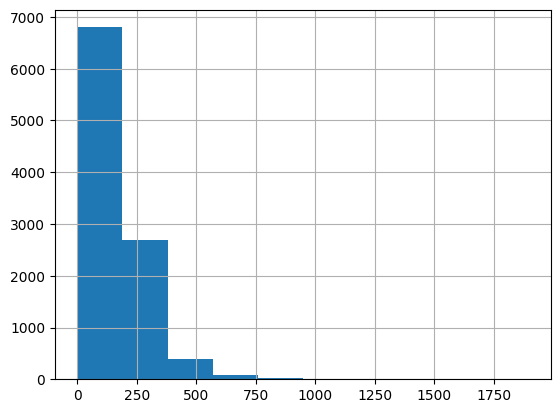

In [23]:
# see histogram of len(cooking_method) for df
df['cooking_method'].apply(lambda x: len(x.split())).hist()

In [24]:
# count how many are above 512
df['cooking_method'].apply(lambda x: len(x.split())).apply(lambda x: x > 512).sum()

173

In [25]:
# drop these instances
df = df[df['cooking_method'].apply(lambda x: len(x.split())).apply(lambda x: x <= 512)]

In [26]:
df['cooking_method'].apply(lambda x: len(x.split())).apply(lambda x: x > 512).sum()

0

In [27]:
X = df['cooking_method']
y = df['Veg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [28]:
len(X_train), len(X_val), len(X_test)

(5502, 1376, 2949)

In [29]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [34]:
def preprocess_data(data):
    # take a batch of texts
    text = data["cooking_method"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
    
    label = data["Veg"]
    
    # create numpy array of shape (batch_size, 1) for single label
    labels_matrix = np.array(label).reshape(-1, 1)
    
    encoding["labels"] = labels_matrix.tolist()
    
    return encoding

In [35]:
encoded_dataset = df.map(preprocess_data, batched=True)

TypeError: preprocess_data() got an unexpected keyword argument 'batched'